# Jakub Bandurski, Michał Bryzik, Kacper Gruca
## Text Mining and Social Media Mining Project

In [13]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from sklearn.metrics import confusion_matrix
from gensim.models import word2vec
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("../data/nsfw_cleaned.pkl")

In [3]:
df.head()

,body,numberOfComments,over18,upVotes
0,didnt happen like year ago feel like fever dre...,95,False,392
1,f alway say 's ugli old stuff like nobodi like...,244,True,867
2,hi im f dental assist clean accident get prick...,265,False,920
3,context wife f parent beauti toddler ym f rent...,138,True,1372
4,yesterday 's fuckup spill go crazi f frequent ...,31,False,45


In [4]:
df.isnull().sum()

body                0
numberOfComments    0
over18              0
upVotes             0
dtype: int64

In [5]:
# split into train and test subsets
split = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

for train_index, test_index in split.split(df,
                                           df["over18"]): 
    df_train = df.reindex(train_index)
    df_test = df.reindex(test_index)

In [6]:
df_train = df_train.drop(columns=["numberOfComments", "upVotes"])

In [7]:
df_train

,body,over18
608,post mobil 'm sorri format issu post throw awa...,False
488,get jacket steal bar around thank airpod abl b...,False
583,okay actual happen coupl month ago realiz happ...,False
160,'m gon na real happen back like novemb 's bad ...,False
555,hi detail obscur safeti reason apolog format p...,False
...,...,...
362,someth remind thought 'd post updat 've lose o...,False
636,saturday okay mayb rant feel dumb go second da...,False
106,mom tri plastic contain look exactli like pot ...,False
721,technic yesterday whatev 've decid studi music...,False


In [8]:
len(df_train), len(df_test)

(665, 222)

In [9]:
df_train["over18"].value_counts()/len(df_train)

False    0.822556
True     0.177444
Name: over18, dtype: float64

In [10]:
df_test["over18"].value_counts()/len(df_test)

False    0.81982
True     0.18018
Name: over18, dtype: float64

In [11]:
models_params = [
    {'name': 'SVC', 'classifier': SVC(), 'param_grid': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}},
    {'name': 'Logistic Regression', 'classifier': LogisticRegression(class_weight='balanced'), 'param_grid': {'classifier__C': [1], 'classifier__solver': ['saga']}},
    {'name': 'Logistic Regression_L2', 'classifier': LogisticRegression(class_weight='balanced'), 'param_grid': {'classifier__C': [1], 'classifier__penalty':['l2'], 'classifier__solver': ['saga']}},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier(class_weight='balanced'), 'param_grid': {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10, 20]}}
]

Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVC - Best F1 Score on Validation: 0.28138615770194714


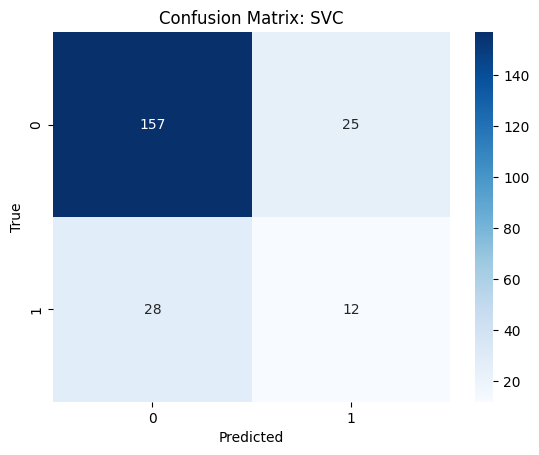

SVC - F1 Score on Test: 0.3116883116883117

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Best F1 Score on Validation: 0.38090992986341826


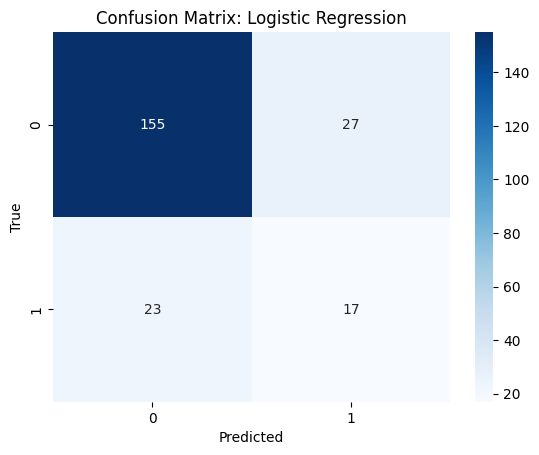

Logistic Regression - F1 Score on Test: 0.40476190476190477

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression_L2 - Best F1 Score on Validation: 0.37655383500566453


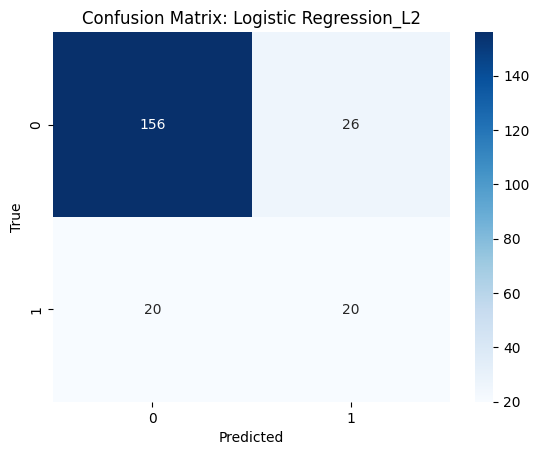

Logistic Regression_L2 - F1 Score on Test: 0.46511627906976744

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest - Best F1 Score on Validation: 0.1340399385560676


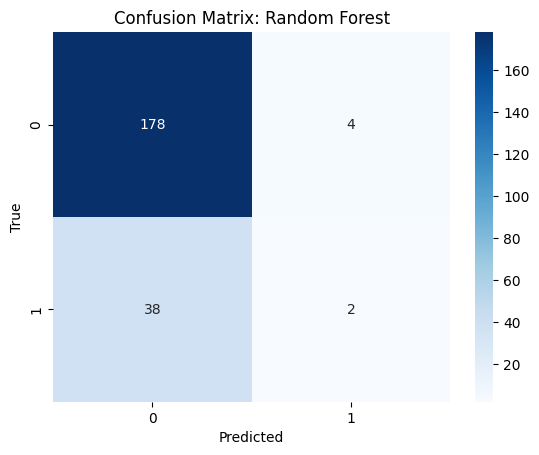

Random Forest - F1 Score on Test: 0.08695652173913045



In [14]:
for model_params in models_params:
    random.seed(20)
    # Create a pipeline for TF-IDF Vectorization and model training
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', model_params['classifier'])
    ])

    # Combine parameter grid from models_params with TF-IDF specific parameters
    param_grid = {
        'tfidf__max_features': [1000, 5000, None],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        **model_params['param_grid']
    }

    # Perform grid search with F1 score as the scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(df_train['body'], df_train["over18"])

    # Get best model
    best_model = grid_search.best_estimator_

    # Predict on test data
    predictions = best_model.predict(df_test['body'])
    conf_matrix = confusion_matrix(df_test["over18"], predictions)
    
    # Print F1 score on validation (grid_search) point
    print(f"{model_params['name']} - Best F1 Score on Validation: {grid_search.best_score_}")

    # Print confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix: {model_params['name']}" )
    plt.show()
    
    # Calculate F1 score on test data
    f1_test = f1_score(df_test["over18"], predictions)
    print(f"{model_params['name']} - F1 Score on Test: {f1_test}\n")

In [15]:
# Tokenize sentences
tokenized_train_sentences = [sentence.split() for sentence in df_train['body']]
tokenized_test_sentences = [sentence.split() for sentence in df_test['body']]

# Train Word2Vec model
word2vec_model = word2vec.Word2Vec(sentences=tokenized_train_sentences, vector_size=100, window=5, min_count=1, workers=10)

# Transform tokenized sentences using Word2Vec
X_train_embedded = np.array([np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(word2vec_model.vector_size)], axis=0) for sentence in tokenized_train_sentences])
X_test_embedded = np.array([np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(word2vec_model.vector_size)], axis=0) for sentence in tokenized_test_sentences])

In [16]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVC - Best F1 Score on Validation: 0.0


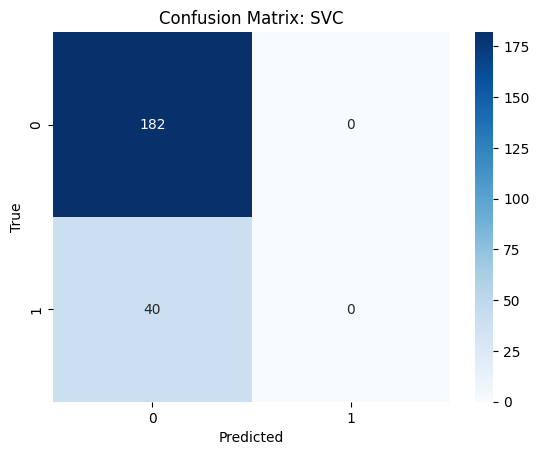

SVC - F1 Score on Test: 0.0

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic Regression - Best F1 Score on Validation: 0.2951627774481785


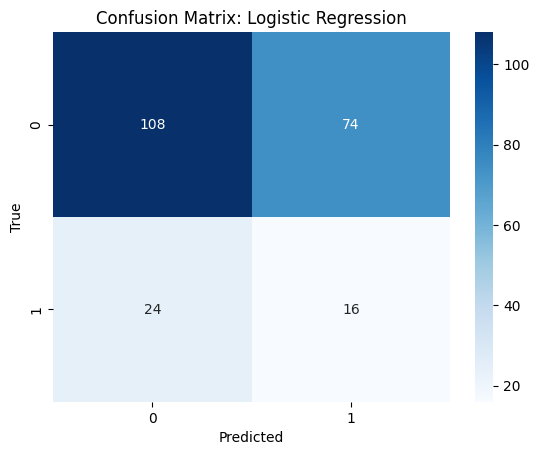

Logistic Regression - F1 Score on Test: 0.24615384615384614

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic Regression_L2 - Best F1 Score on Validation: 0.2951627774481785


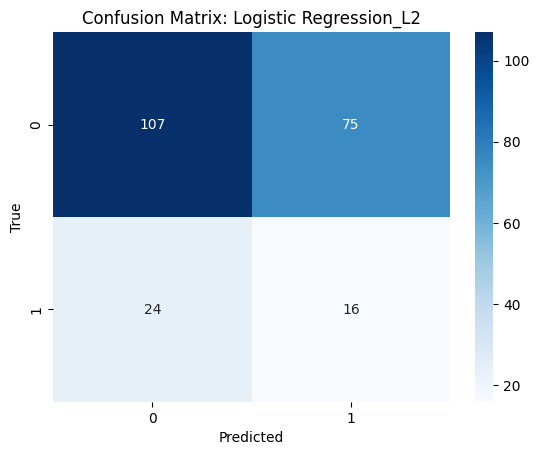

Logistic Regression_L2 - F1 Score on Test: 0.24427480916030536

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Forest - Best F1 Score on Validation: 0.048666666666666664


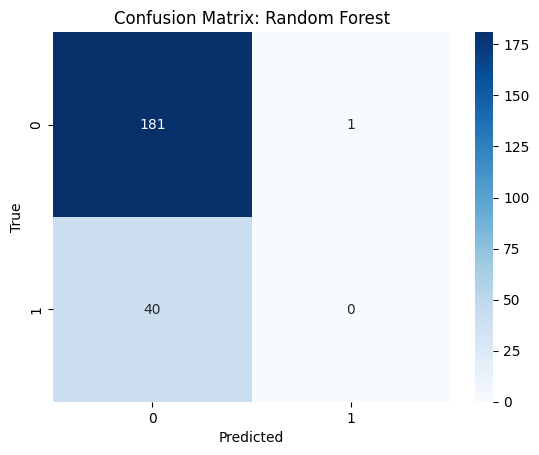

Random Forest - F1 Score on Test: 0.0



In [17]:

for model_params in models_params:
    # Create a pipeline for clustering and model training
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the features
        ('pca', PCA(n_components=100)),  # Principal Component Analysis for dimensionality reduction
        ('classifier', model_params['classifier'])
    ])

    # Combine parameter grid from models_params with embedding specific parameters
    param_grid = {
        **model_params['param_grid']
    }

    # Perform grid search with F1 score as the scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_train_embedded, df_train["over18"])

    # Get best model
    best_model = grid_search.best_estimator_

    # Predict on test data
    predictions = best_model.predict(X_test_embedded)
    conf_matrix = confusion_matrix(df_test["over18"], predictions)
    
    # Print F1 score on validation (grid_search) point
    print(f"{model_params['name']} - Best F1 Score on Validation: {grid_search.best_score_}")

    # Print confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix: {model_params['name']}" )
    plt.show()
    
    # Calculate F1 score on test data
    f1_test = f1_score(df_test["over18"], predictions)
    print(f"{model_params['name']} - F1 Score on Test: {f1_test}\n")